In [1]:
from holodecml.data import load_raw_datasets, load_unet_datasets
from holodecml.losses import unet_loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [9]:
path_data = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/"
num_particles = "medium"
output_cols = ["x", "y", "z", "d", "hid"]
subset = 0.10
scaler_out = MinMaxScaler()
num_bins = False


In [10]:
train_inputs, train_outputs, valid_inputs, valid_outputs = load_unet_datasets(path_data, num_particles, output_cols,
                                                                              scaler_out, subset, num_bins)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
)
from tensorflow.keras.optimizers import Adam, SGD


In [5]:
def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def attention_gate(inp_1, inp_2, n_intermediate_filters):
    """Attention gate. Compresses both inputs to n_intermediate_filters filters before processing.
       Implemented as proposed by Oktay et al. in their Attention U-net, see: https://arxiv.org/abs/1804.03999.
    """
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    """Performs concatenation of upsampled conv_below with attention gated version of skip-connection
    """
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])


def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c


In [6]:
def custom_unet(
    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",  # 'deconv' or 'simple'
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=16,
    num_layers=3,
    output_activation="sigmoid",
):  # 'sigmoid' or 'softmax'

    """
    Customisable UNet architecture (Ronneberger et al. 2015 [1]).
    Arguments:
    input_shape: 3D Tensor of shape (x, y, num_channels)
    num_classes (int): Unique classes in the output mask. Should be set to 1 for binary segmentation
    activation (str): A keras.activations.Activation to use. ReLu by default.
    use_batch_norm (bool): Whether to use Batch Normalisation across the channel axis between convolutional layers
    upsample_mode (one of "deconv" or "simple"): Whether to use transposed convolutions or simple upsampling in the decoder part
    dropout (float between 0. and 1.): Amount of dropout after the initial convolutional block. Set to 0. to turn Dropout off
    dropout_change_per_layer (float between 0. and 1.): Factor to add to the Dropout after each convolutional block
    dropout_type (one of "spatial" or "standard"): Type of Dropout to apply. Spatial is recommended for CNNs [2]
    use_dropout_on_upsampling (bool): Whether to use dropout in the decoder part of the network
    use_attention (bool): Whether to use an attention dynamic when concatenating with the skip-connection, implemented as proposed by Oktay et al. [3]
    filters (int): Convolutional filters in the initial convolutional block. Will be doubled every block
    num_layers (int): Number of total layers in the encoder not including the bottleneck layer
    output_activation (str): A keras.activations.Activation to use. Sigmoid by default for binary segmentation
    Returns:
    model (keras.models.Model): The built U-Net
    Raises:
    ValueError: If dropout_type is not one of "spatial" or "standard"
    """

    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    x = inputs

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2  # double the number of filters with each layer

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2  # decreasing number of filters with each layer
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    outputs = Conv2D(num_classes, (1, 1), activation=output_activation)(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [7]:
input_shape = np.expand_dims(train_inputs, axis=-1).shape[1:]
model = custom_unet(
    input_shape,
    use_batch_norm=True,
    num_classes=3,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid',
    use_attention=True
)


In [8]:
model.compile(
    optimizer=Adam(lr=0.0001),
    loss=unet_loss
)


In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 400, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 600, 400, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 600, 400, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 600, 400, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
history = model.fit(
    np.expand_dims(train_inputs, axis=-1),
    train_outputs,
    batch_size=8,
    epochs=40,
    validation_data=(np.expand_dims(valid_inputs, axis=-1), valid_outputs)
)


Epoch 1/40
10000/10000 [==============================] - 5895s 589ms/step - loss: 0.1398 - val_loss: 0.0911
Epoch 2/40
10000/10000 [==============================] - 5300s 530ms/step - loss: 0.0905 - val_loss: 0.0903
Epoch 3/40
10000/10000 [==============================] - 5297s 530ms/step - loss: 0.0900 - val_loss: 0.0900
Epoch 4/40
10000/10000 [==============================] - 5301s 530ms/step - loss: 0.0898 - val_loss: 0.0901
Epoch 5/40
10000/10000 [==============================] - 5305s 531ms/step - loss: 0.0897 - val_loss: 0.0908
Epoch 6/40
10000/10000 [==============================] - 5302s 530ms/step - loss: 0.0896 - val_loss: 0.0920
Epoch 7/40
 6445/10000 [==================>...........] - ETA: 30:07 - loss: 0.0894

In [ ]:
valid_outputs_pred = model.predict(np.expand_dims(valid_inputs, axis=-1),
                                     batch_size=32)


In [ ]:
import xarray as xr

valid_outputs_pred_da = xr.DataArray(valid_outputs_pred,
                                     coords={"hid": np.arange(valid_outputs_pred.shape[0]),
                                             "x": np.arange(valid_outputs_pred.shape[1]),
                                             "y": np.arange(valid_outputs_pred.shape[2]),
                                             "output": ["p", "z", "d"]},
                                     dims=("hid", "x", "y", "output"),
                                     name="valid_pred_scaled")

In [ ]:
from os.path import join

path_save = "/glade/p/cisl/aiml/ggantos/holodec/unet/base_40/"
model.save(path_save, save_format="tf")
model.save_weights(path_save + '_weights', save_format='tf')
valid_outputs_pred_da.to_netcdf(join(path_save, "valid_outputs_pred.nc"))
for k in history.history.keys():
    np.savetxt(join(path_save, k+".csv"), history.history[k])


In [102]:
import xarray as xr

ds = xr.open_dataset("/glade/p/cisl/aiml/ggantos/holodec/unet/MSE_40/valid_outputs_pred.nc")
ds_np = ds.to_array().values[0]
type(ds_np)

numpy.ndarray

/glade/work/ggantos/ncar_20200417/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


28.98537


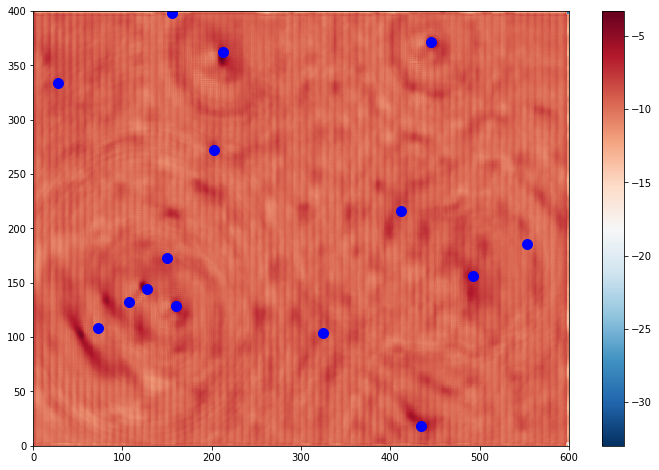

In [103]:
fig=plt.figure(figsize=(12, 8))
plt.pcolormesh(np.log(ds_np[0, :, :, 0]).T, cmap="RdBu_r")
plt.colorbar()
plt.scatter(np.where(image_true > 0)[0], np.where(image_true > 0)[1], color='blue', s=100, label="True")
print(np.sum(ds_np[0, :, :, 0]))
plt.show()

28.98537


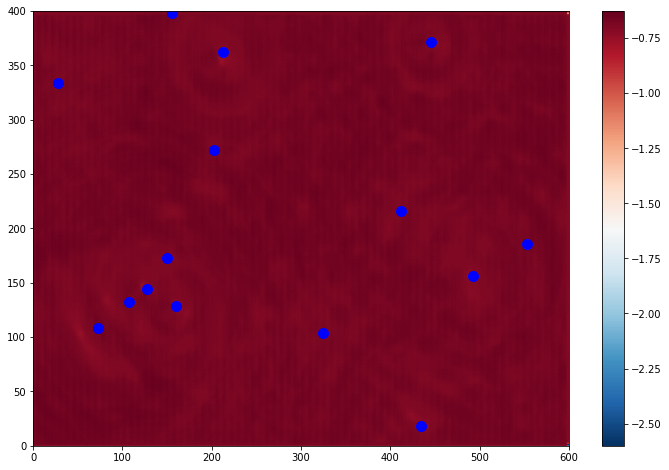

In [93]:
fig=plt.figure(figsize=(12, 8))
plt.pcolormesh(np.log(ds_np[0, :, :, 1]).T, cmap="RdBu_r")
plt.colorbar()
plt.scatter(np.where(image_true > 0)[0], np.where(image_true > 0)[1], color='blue', s=100, label="True")
print(np.sum(ds_np[0, :, :, 0]))
plt.show()

28.98537


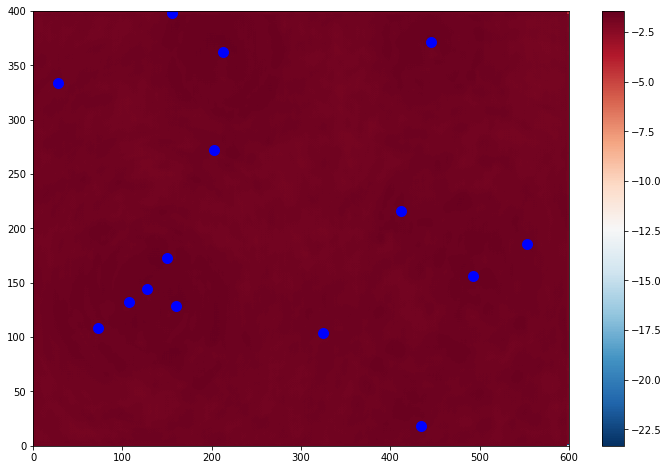

In [94]:
fig=plt.figure(figsize=(12, 8))
plt.pcolormesh(np.log(ds_np[0, :, :, 2]).T, cmap="RdBu_r")
plt.colorbar()
plt.scatter(np.where(image_true > 0)[0], np.where(image_true > 0)[1], color='blue', s=100, label="True")
print(np.sum(ds_np[0, :, :, 0]))
plt.show()

In [62]:
400*600 - np.sum(ds_np[0, :, :, 0])

239968.7685661316

204800.95


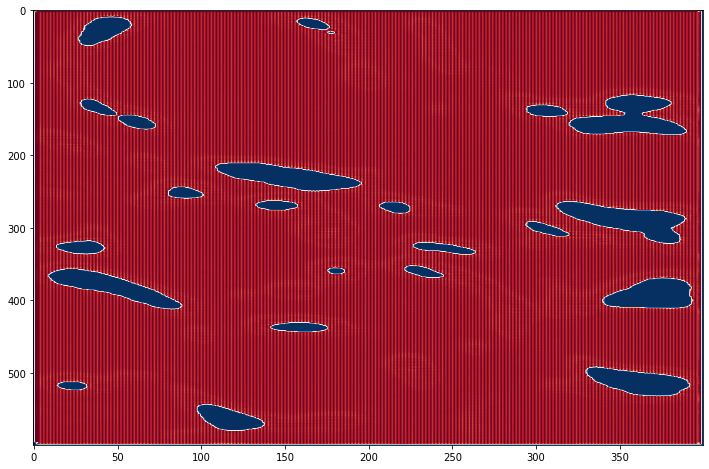

In [63]:
fig=plt.figure(figsize=(12, 8))
plt.imshow(ds_np[0, :, :, 1], interpolation='bilinear', cmap="RdBu_r", aspect='auto', vmin=0, vmax=1)
print(np.sum(ds_np[0, :, :, 1]))
plt.savefig("./unet_z.png", dpi=200, bbox_inches="tight")

35167.816


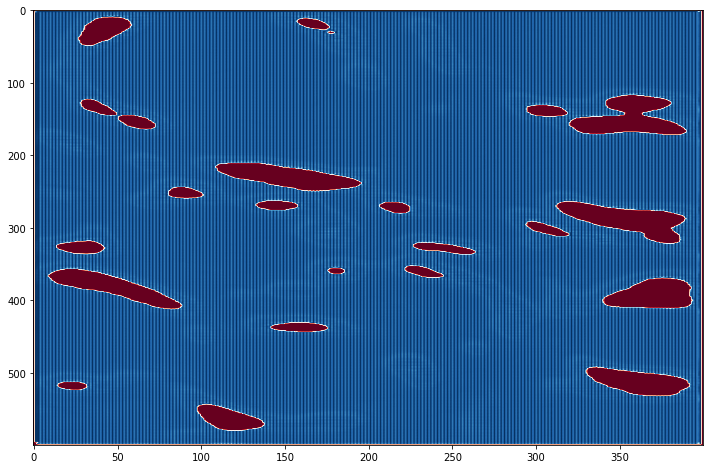

In [64]:
fig=plt.figure(figsize=(12, 8))
plt.imshow(ds_np[0, :, :, 2], interpolation='bilinear', cmap="RdBu_r", aspect='auto', vmin=0, vmax=1)
print(np.sum(ds_np[0, :, :, 2]))
plt.savefig("./unet_d.png", dpi=200, bbox_inches="tight")


13.0


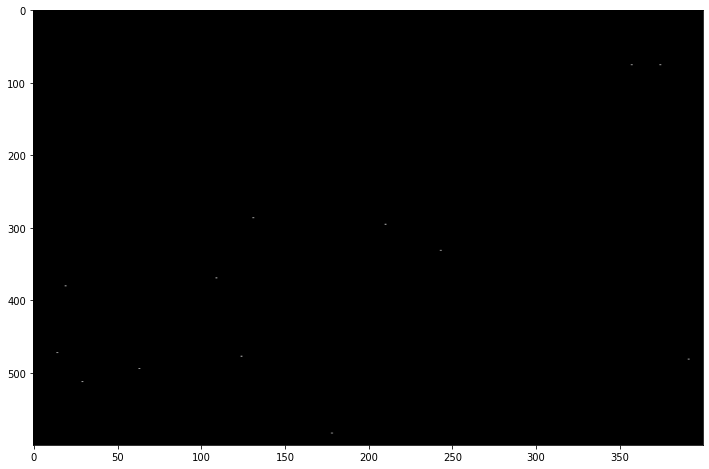

In [65]:
fig=plt.figure(figsize=(12, 8))
plt.imshow(train_outputs[0, :, :, 0], interpolation='bilinear', cmap=plt.cm.gray, aspect='auto', vmin=0, vmax=1)
print(np.sum(train_outputs[0, :, :, 0]))
plt.show()

In [66]:
np.max(ds_np[0, :, :, 0])

0.006878104

In [67]:
unique_elements, counts_elements = np.unique(ds_np[0, :, :, 0], return_counts=True)

In [68]:
unique_elements

array([8.8948291e-08, 8.9067008e-08, 9.4733231e-08, ..., 3.0354909e-03,
       4.7036530e-03, 6.8781041e-03], dtype=float32)

In [69]:
counts_elements

array([1, 1, 1, ..., 1, 1, 1])

In [70]:
pred_argsort = ds_np[0, :, :, 0].flatten().argsort()
print(pred_argsort[-13:][::-1])

[239999      0    399  16045 110611 121899    400 148811    398 160059
 117131 238800   9632]


In [71]:
image = ds_np[0, :, :, 0]
coords = []
for i in pred_argsort[-13:][::-1]:
    coord = np.array([c[0] for c in np.where(image == image.flatten()[i])])
    coords.append(coord)
coords = np.stack(coords)
coords

array([[599, 399],
       [  0,   0],
       [  0, 399],
       [ 40,  45],
       [276, 211],
       [304, 299],
       [  1,   0],
       [372,  11],
       [  0, 398],
       [400,  59],
       [292, 331],
       [597,   0],
       [ 24,  32]])

In [72]:
valid_inputs.shape

(1000, 600, 400)

In [99]:
image_true = valid_outputs[0, :, :, 0]
coords_true = np.where(image_true > 0)

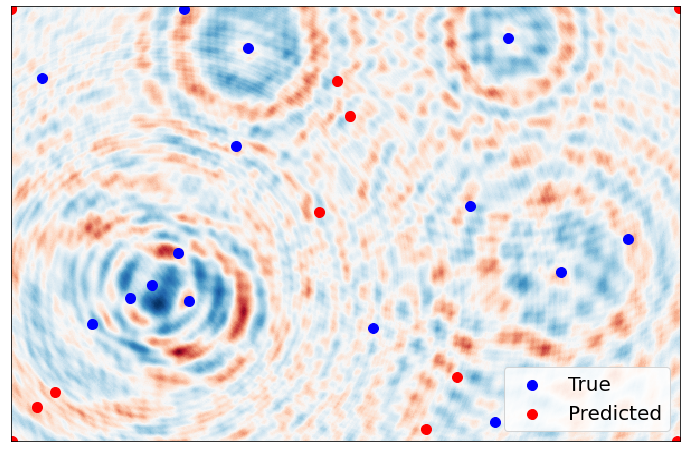

In [100]:
plt.figure(figsize=(12, 8))
x_vals = np.linspace(0, 600, valid_inputs[0, :, :].shape[0])
y_vals = np.linspace(0, 400, valid_inputs[0, :, :].shape[1])
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x_vals, y_vals, valid_inputs[0, :, :].T, cmap="RdBu_r")
plt.scatter(np.where(image_true > 0)[0], np.where(image_true > 0)[1], color='blue', s=100, label="True")
plt.scatter(coords[:, 0], coords[:, 1], color='red', s=100, label="Predicted")
plt.legend(fontsize=20)
plt.savefig("./unet.png", dpi=200, bbox_inches="tight")
